# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy, scipy, and scanpy in addlition to screcode.

In [1]:
import screcode
import numpy as np
import scanpy as sc

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [ ]:
input_filename = 'data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata.var_names_make_unique()

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [3]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 15789, '#non-significant genes': 9322, '#silent genes': 11490, 'ell': 165, 'Elapsed_time': '277.2905[sec]'}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [4]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance_RECODE', 'normalized_variance_RECODE', 'significance_RECODE'
    obsm: 'RECODE'

## Performance check
Check applicability:

applicabity: (A) Strongly applicable


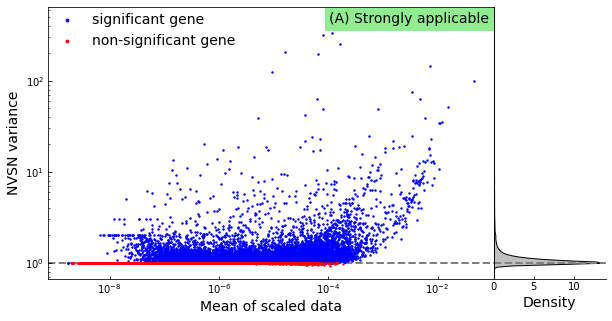

In [5]:
recode.check_applicability()

Show scatter plots of mean versus variance of log-scaled data before and after RECODE:

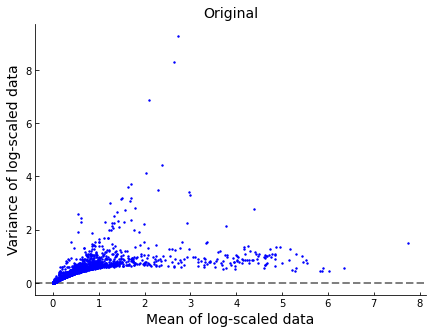

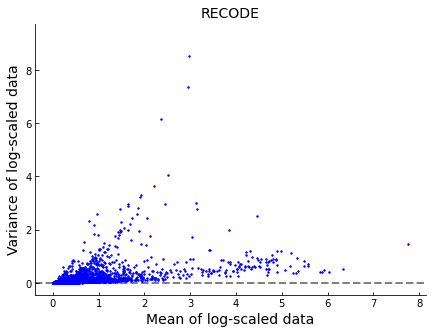

In [6]:
recode.plot_mean_variance()

Show scatter plots of mean vs CV (coefficient of variation) before and after RECODE:

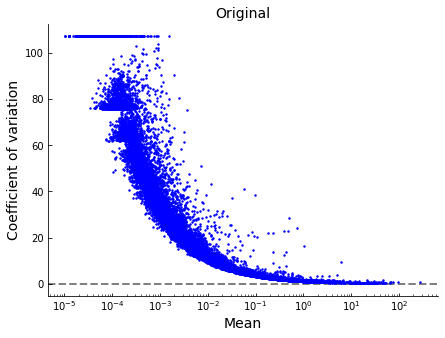

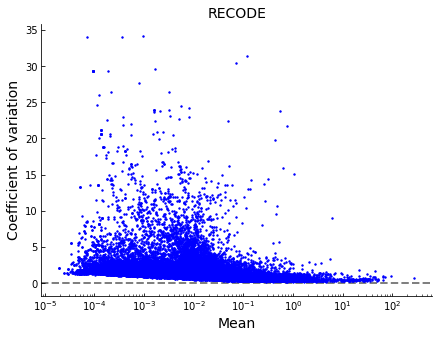

In [7]:
recode.plot_mean_cv()

Check the log.

In [8]:
recode.log_

{'seq_target': 'RNA',
 '#significant genes': 15789,
 '#non-significant genes': 9322,
 '#silent genes': 11490,
 'ell': 165,
 'Elapsed_time': '277.2905[sec]',
 'Applicability': '(A) Strongly applicable',
 'Rate of 0 < normalized variance < 0.9': '0%',
 'Peak density of normalized variance': 1.0161445413001506}